<a href="https://colab.research.google.com/github/dowrave/RoadToImageSeg_GAN/blob/main/220510_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[텐서플로우 CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan?hl=ko)

In [4]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE # 파이프라인 간 Overlap을 지원함 (동시 실행)

In [7]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info = True, as_supervised = True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1A7QYY/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1A7QYY/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1A7QYY/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete1A7QYY/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def random_crop(image):
  """ 이미지 랜덤한 위치를 고정된 크기로 자름 """
  cropped_image = tf.image.random_crop(
      image, size = [IMG_HEIGHT, IMG_WIDTH, 3]
  )
  return cropped_image

def normalize(image):
  """ 이미지 [-1,1]로 정규화"""
  image = tf.cast(image, tf.float32)
  image = (image / 127.5 - 1)
  return image

def random_jitter(image): # ??? : Jitter가 뭐죠?
  """ 이미지 286 * 286 * 3으로 변경 -> random_crop & mirroring """
  image = tf.image.resize(image, [286, 286],
                          method = tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Nearest Neighbor Interpolation
  # 256 * 256 * 3
  image = random_crop(image)

  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label): 
  image = normalize(image)
  return image

In [13]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE
).cache().shuffle(BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE
).cache().shuffle(BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls = AUTOTUNE
).cache().shuffle(BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls = AUTOTUNE
).cache().shuffle(BUFFER_SIZE).batch(1)

In [14]:
sample_horse = next(iter(train_horses)) # 데이터구조 : BatchDataset - iter는 반복 가능한 형태로, next는 1개씩 끄집어줌
sample_zebra = next(iter(train_zebras))

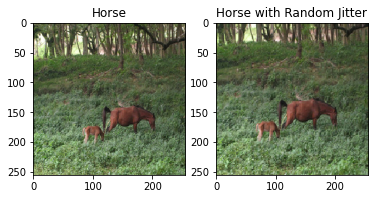

In [20]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with Random Jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

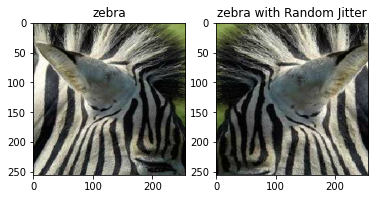

In [21]:
plt.subplot(121)
plt.title('zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('zebra with Random Jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

### PIX2PIX 모델 가져오기 & 재사용
- 차이점
1. CycleGAN은 Instance Normalization을 이용함
2. 논문에선 resnet 기반의 생성기를 이용하며, 이 튜토리얼에서는 단순화를 위해 수정된 unet 생성기를 사용함

- 훈련 대상
1. G(생성기1) : 이미지 X를 Y로 변환하는 방법 학습
2. F(생성기2) : 이미지 Y를 X로 변환하는 방법 학습
3. D_X(판별자1) : 이미지 X와 생성된 이미지 X(=F(Y))를 구별하는 방법 학습
4. D_Y(판별자2) : 이미지 Y와 생성된 이미지 Y(=G(X))를 구별하는 방법 학습

In [23]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type = 'instancenorm')

discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm', target = False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm', target = False)

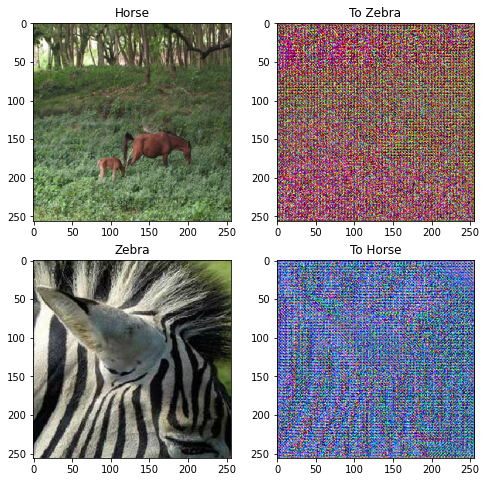

In [24]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize = (8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

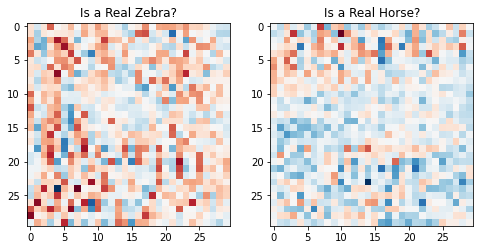

In [25]:
plt.figure(figsize = (8, 8))

plt.subplot(121)
plt.title("Is a Real Zebra?")
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(122)
plt.title("Is a Real Horse?")
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

## 손실함수
- pix2pix에서는 훈련 데이터 x와 노이즈 z를 쌍을 묶었지만, 여기서는 그 쌍이 의미가 있다는 보장이 없다.
- 그래서 저자들은 주기 일관성 손실을 제안함

In [26]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

- G, D의 손실은 pix2pix와 유사함

In [40]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5 # 0.5??

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated) # 새삼 복습하지만 generator의 결과는 G에선 1과, D에선 0과 비교하는 것에 유의

### 주기 일관성
- 예를 들어 한국어 -> 영어 -> 한국어로 번역을 2회 했다면, 돌아오는 한국어는 입력되는 한국어와 같아야 함
- 이 때 입력 한국어와 출력 한국어 간 오차를 생각해볼 수 있음
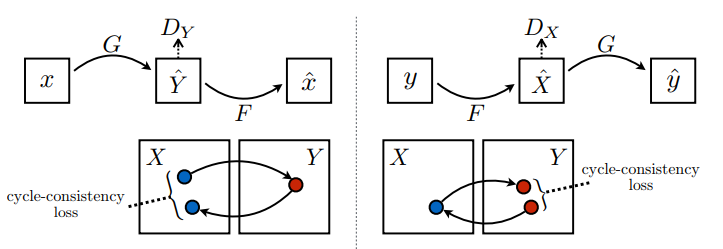

In [28]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [30]:
# 다른 loss 로 정의되는 것이, G 혹은 F로 1회 변환된 값과 원래 자신을 비교하는 loss가 있음. 이를 identity_loss라고 함
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [36]:
# 생성기, 판별자의 옵티마이저 초기화
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

## 체크포인트

In [38]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g = generator_g,
                           generator_f = generator_f,
                           discriminator_x = discriminator_x,
                           discriminator_y = discriminator_y,
                           generator_g_optimizer = generator_g_optimizer,
                           generator_f_optimizer = generator_f_optimizer,
                           discriminator_x_optimizer = discriminator_x_optimizer,
                           discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest Checkpoint Restored")

## 훈련 : 논문보다 적은 40에포크로 진행, 정확성 떨어질 수 있음

In [39]:
EPOCHS = 40

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize = (12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    
    # 픽셀 값 [0, 1]로 넣기
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

### 훈련 1스텝
- 예측 -> 손실 계산 -> 역전파로 그래디언트 계산 -> 옵티마이저에 적용
- 우리가 아는 DL의 훈련과정과 완전히 동일함

In [43]:
@tf.function
def train_step(real_x, real_y):
  # Tape를 왜 쓴다? gradient 계산하려고 쓴다!
  with tf.GradientTape(persistent = True) as tape:
    # G : X -> Y / F : Y -> X

    fake_y = generator_g(real_x, training = True)
    cycled_x = generator_f(fake_y, training = True)
    fake_x = generator_f(real_y, training = True)
    cycled_y = generator_g(fake_x, training = True)

    # same 값은 identity_loss 구할 때 사용
    same_x = generator_f(real_x, training = True)
    same_y = generator_g(real_y, training = True)

    disc_real_x = discriminator_x(real_x, training = True)
    disc_real_y = discriminator_y(real_y, training = True)

    disc_fake_x = discriminator_x(fake_x, training = True)
    disc_fake_y = discriminator_y(fake_y, training = True)

    # loss 값 계산
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total G Loss : adversarial Loss + Cycle Loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
  # Gradient 값 계산(Tape 영역 밖임!)
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_g_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  # Gradient 값 Optimizer에 적용
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

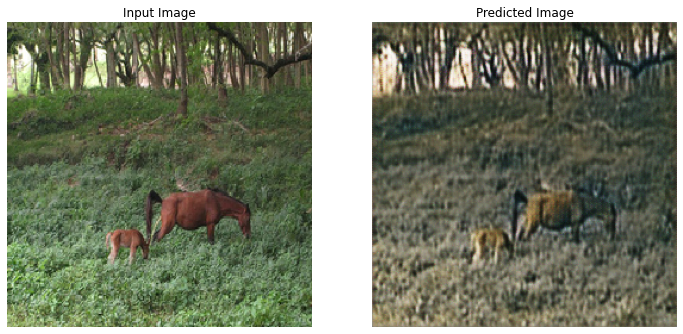

Time taken for epch 1 is 217.5219054222107 sec 



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print(".", end = "")
    n += 1

    clear_output(wait = True)
    # Consistent Image를 써서 Progress가 확실히 보이도록 하자고 하네요
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print("Saving Checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))

    print("Time taken for epoch {} is {} sec \n".format(epoch +1, time.time()-start))

In [ ]:
# 테스트 데이터 세트를 사용하여 생성
for inp in test_horses.take(5):
  generate_images(generator_g, inp)